# EDA Análisis exploratorio de datos

## Importando librerías

In [2]:
import re
import sketch
import numpy as np 
import pandas as pd 
#import pandas_alive
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geojson
import folium
from folium.plugins import HeatMap
from summarytools import dfSummary

### Ingesta de datos desde el dataset limpio `siniestros_limpio`

In [3]:
df= pd.read_csv("data/siniestos_limpio.csv")
df.head(3)

,Id,Fecha,Año,Mes,Día,Día semana,Hora completa,Hora,Num víctimas,Participantes,...,Calle,Cruce,Dirección normalizada,Comuna,Barrios,Xy (caba),Coordenada x,Coordenada y,Pos x,Pos y
0,2016-0001,2016-01-01,2016.0,1.0,1.0,Viernes,04:00:00,4.0,1,MOTO-AUTO,...,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",Comuna 8,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,Point (98896.78238426 93532.43437792),98896.782384,93532.434378,-58.475340,-34.687570
1,2016-0002,2016-01-02,2016.0,1.0,2.0,Sabado,01:15:00,1.0,1,AUTO-PASAJEROS,...,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",Comuna 9,LINIERS - MATADEROS - PARQUE AVELLANEDA,Point (95832.05571093 95505.41641999),95832.055711,95505.416420,-58.508775,-34.669777
2,2016-0003,2016-01-03,2016.0,1.0,3.0,Domingo,07:00:00,7.0,1,MOTO-AUTO,...,ENTRE RIOS AV.,NaN,ENTRE RIOS AV. 2034,Comuna 1,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,Point (106684.29090040 99706.57687843),106684.290900,99706.576878,-58.390403,-34.631894


### Outliers

Se realiza la busqueda de datos con valores atípicos en las features, y se analiza si es necesario eliminarlos.  

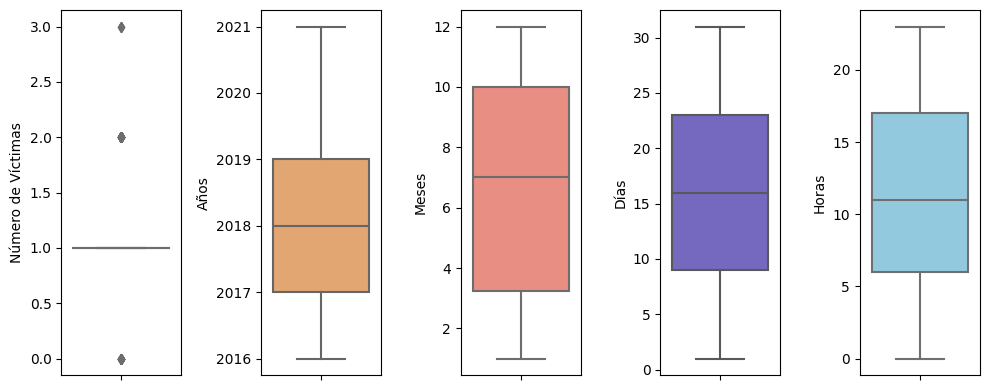

In [4]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 4))

# Crear subplots para los gráficos 
plt.subplot(1, 5, 1) 
sns.boxplot(data=df, y='Num víctimas', color = "#FA8072")
plt.ylabel('Número de Víctimas')

plt.subplot(1, 5, 2) 
sns.boxplot(data=df, y='Año', color = "#F4A460")
plt.ylabel('Años')

plt.subplot(1, 5, 3) 
sns.boxplot(data=df, y='Mes', color = "#FA8072")
plt.ylabel('Meses')

plt.subplot(1, 5, 4) 
sns.boxplot(data=df, y='Día', color = "#6A5ACD")
plt.ylabel('Días')

plt.subplot(1, 5, 5) 
sns.boxplot(data=df, y='Hora', color = "#87CEEB")
plt.ylabel('Horas')

# Ajustar espaciado entre subplots
plt.tight_layout()

plt.show()

#### **Conclusión**
- Los Outliers que se encuentran en feature `Num víctimas` (valores 2 ó 3), se producen debido a que en la mayoria de los casos el registro es el valor uno (1); con respecto a las victimas en los siniestros. 

### Variables Númericas

En el dataset hay variables numéricas ó que contienen números; pero su utilización como tales va a depender del contexto de los datos.
En éste caso se utiliza un mapa de correlaciones para examinar si existen, relaciones entre los datos númericos ó se utilizarán como categóricos (en algunos casos), para el correcto análisis 

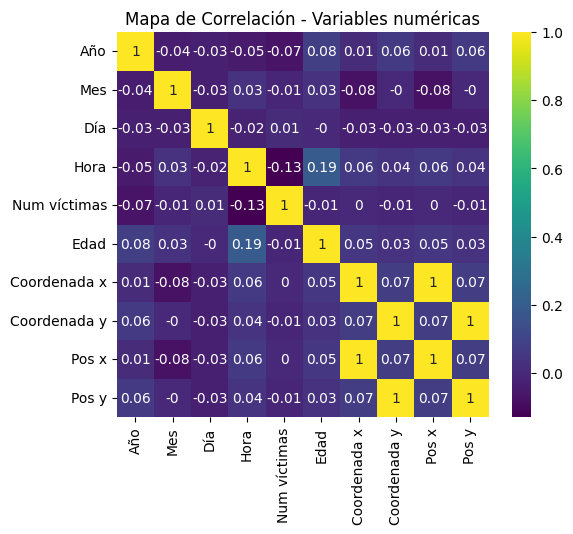

In [5]:
# Generamos un mapa de calor con las correlaciones de los todos los datos que contengan números 
dataNumerica = df.select_dtypes(include=['number']) 
corr = dataNumerica.corr().round(2)

plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="viridis", annot=True)
plt.title('Mapa de Correlación - Variables numéricas')
plt.show()

El cruzamiento de todas las variables numéricas en la matriz resulta con relaciones positivas fuertes entre las features `Coordenada` y `Pos`, lo que resultaría un dato esperable.
Se puede verificar también una **correlacíon positiva leve** entre la variable `Edad` y `Hora`
Las demás correlaciones son negativas, hecho que se esperaba debido a que el `Num víctimas` de un siniestro no se vincula a una fecha u hora puntual.

Debido al objetivo de éste proyecto, que consiste en analizar los siniestros, con el fin de disminuir la cantidad de víctimas fatales; se define comenzar la exploración con la variable `Num víctimas`.

### `Num víctimas`
- Cantidad de víctimas fatales por siniestro vial

In [6]:
df["Num víctimas"].describe()

count    717.000000
mean       1.037657
std        0.294226
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: Num víctimas, dtype: float64

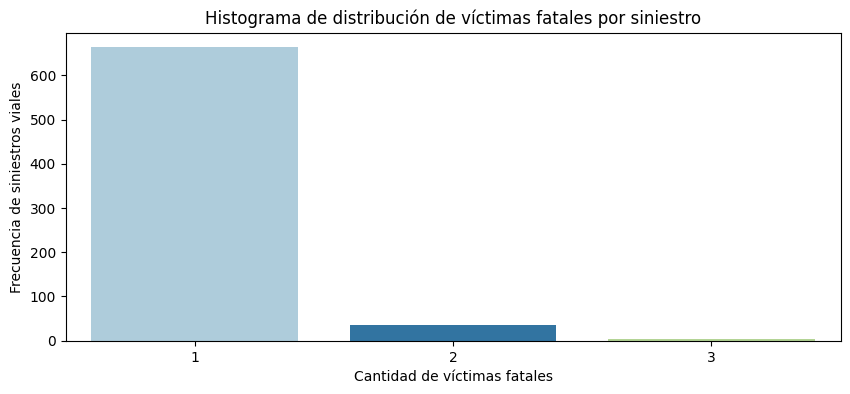

In [7]:
plt.figure(figsize=(10, 4))
# se filtran los valores sin datos o nulos 
df_filtrado = df[df["Num víctimas"] != 0]

#Se cuentan los datos de la columna y se calcula la frecuencia en que se distribuye
sns.countplot(df_filtrado, x='Num víctimas', palette="Paired")

plt.ylabel("Frecuencia de siniestros viales")
plt.xlabel("Cantidad de víctimas fatales")
plt.title("Histograma de distribución de víctimas fatales por siniestro")

plt.show()

#### **Conclusión**
- La cantidad de víctimas fatales que arrojan los siniestros viales es de 1 (una), en la mayoría de los casos. 
- Según los datos estadísticos de la columna el 75% de los siniestros viales tienen 1 víctima.
- Rara vez resulta un siniestro con tres víctimas fatales 

#### Relación `Num vìctimas` con el tiempo - Distribución temporal

Se analizan los datos teniendo en cuenta diferentes horizontes temporales, para corroborar la existencia de algún tipo de evento o patrón importante.

In [8]:
# Agrupar por año y mes, y sumar el número de víctimas
rel_tiempo = df.groupby(['Año', 'Mes'])['Num víctimas'].sum().reset_index()

In [9]:
rel_tiempo

,Año,Mes,Num víctimas
0,2016.0,1.0,8
1,2016.0,2.0,12
2,2016.0,3.0,15
3,2016.0,4.0,9
4,2016.0,5.0,7
...,...,...,...
67,2021.0,8.0,9
68,2021.0,9.0,4
69,2021.0,10.0,5
70,2021.0,11.0,8


In [10]:
#Para la realización del gráfico se transforman los datos a tipo int
rel_tiempo["Año"]= rel_tiempo["Año"].astype("Int64")
rel_tiempo["Mes"]= rel_tiempo["Mes"].astype("Int64")

In [11]:
rel_tiempo

,Año,Mes,Num víctimas
0,2016,1,8
1,2016,2,12
2,2016,3,15
3,2016,4,9
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [12]:
# Combinar AÑO y MES para obtener una sola variable de tiempo, creando la columna "Fecha" como str
rel_tiempo["Fecha"] = rel_tiempo["Año"].astype(str) + '-' + rel_tiempo["Mes"].astype(str)

# Convertir la variable de tiempo a formato datetime
rel_tiempo["Fecha"] = pd.to_datetime(rel_tiempo["Fecha"])

# Ordenar el DataFrame por fecha para que tenga orden cronológico
rel_tiempo = rel_tiempo.sort_values("Fecha")

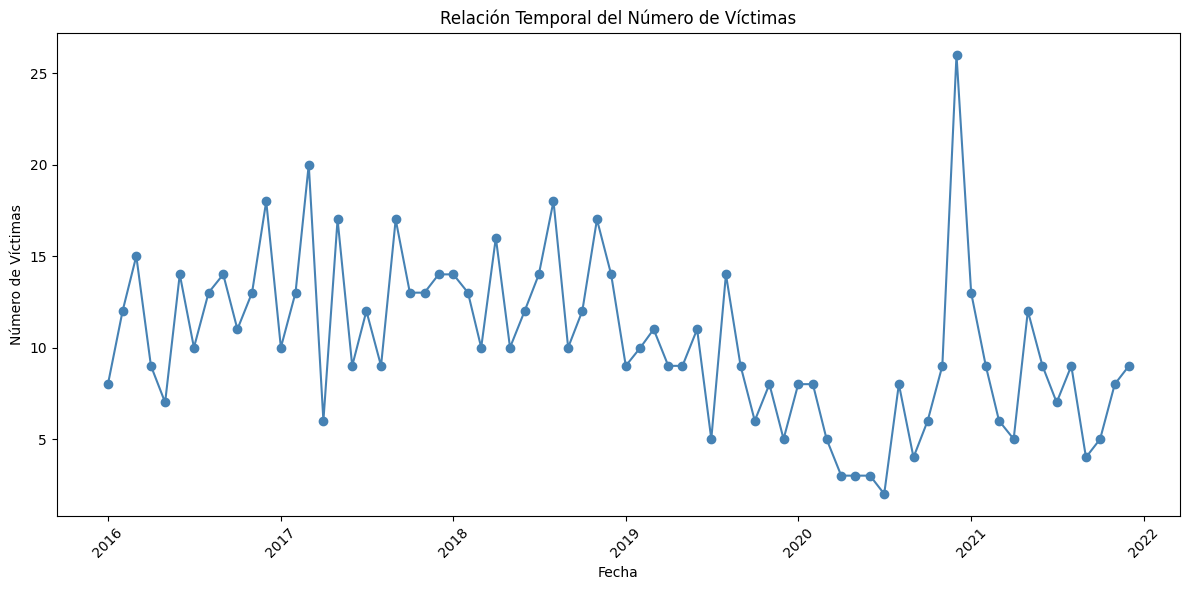

In [13]:
# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(rel_tiempo["Fecha"], rel_tiempo["Num víctimas"], marker='o', color='steelblue')

# Añadir títulos y etiquetas
plt.title('Relación Temporal del Número de Víctimas')
plt.xlabel('Fecha')
plt.ylabel('Número de Víctimas')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### **Conclusión**
- En el gráfico de la relación temporal del número de víctimas, se muestra como las fechas con mayor cantidad de siniestros fatales se dan durante 2017 y 2018; luego se percibe una disminución sostenida en los siguientes años. Sólo hubo un pico, a finales de 2020 superando el mayor número de víctimas mesuales a lo largo de los años analizados (26 víctimas fatales)

### Distribución temporal de víctimas 

#### Distribución mensual de víctimas fatales

Se crea un gráfico de barras que muestra la cantidad de víctimas por mes y agrega etiquetas de número de víctimas en cada barra.

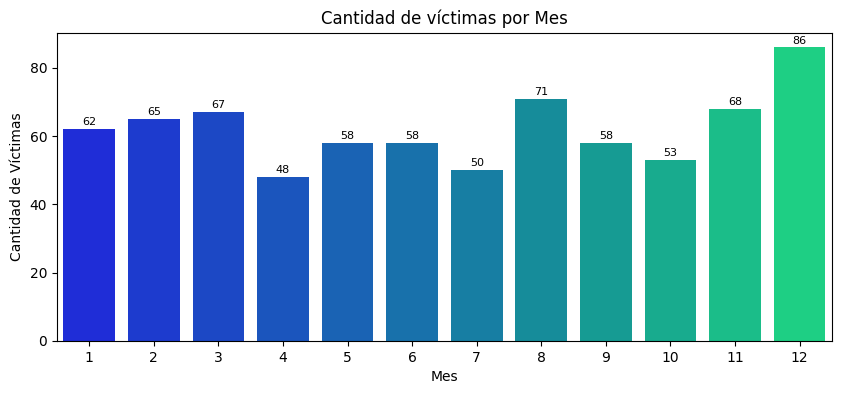

In [46]:
# Se agrupa por la cantidad de víctimas por mes
data = df.groupby(['Mes'])['Num víctimas'].sum().reset_index()
data["Mes"]=data["Mes"].astype("Int64")

# Se grafica
plt.figure(figsize=(10,4))

ax = sns.barplot(x='Mes', y='Num víctimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por Mes')
ax.set_xlabel('Mes') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

#### Distribución diaria de víctimas fatales

Se crea un gráfico de barras que muestra la cantidad de víctimas por día y agrega etiquetas de número de víctimas en cada barra.

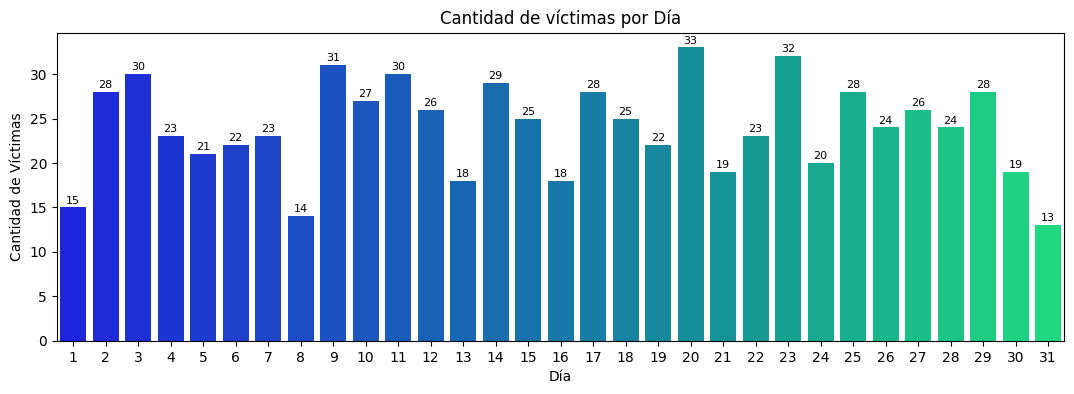

In [45]:
# Se agrupa por la cantidad de víctimas por dia
data = df.groupby(['Día'])['Num víctimas'].sum().reset_index()
data["Día"]=data["Día"].astype("Int64")

# Se grafica
plt.figure(figsize=(13,4))

ax = sns.barplot(x='Día', y='Num víctimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por Día')
ax.set_xlabel('Día') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

Se crea un gráfico de barras que muestra la cantidad de víctimas por día de la semana y agrega etiquetas de número de víctimas en cada barra.

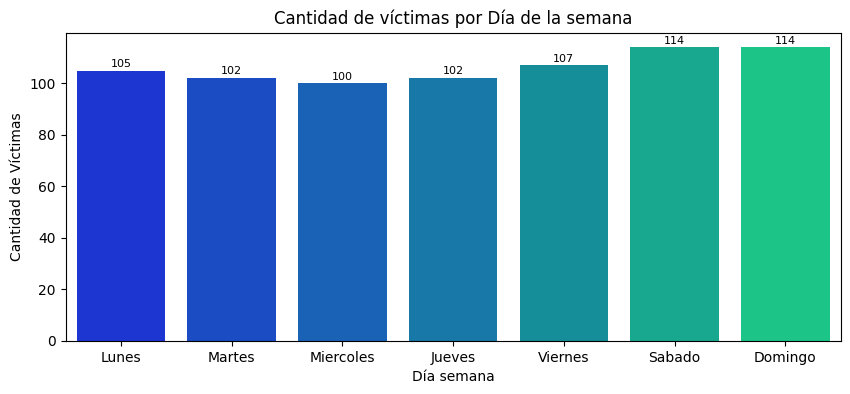

In [44]:
# Se agrupa por la cantidad de víctimas por dia semana
data = df.groupby(['Día semana'])['Num víctimas'].sum().reset_index()


# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'Orden_dia_semana' en el DataFrame para representar el orden numérico de los días de la semana
data['Orden_dia_semana'] = data['Día semana'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data = data.sort_values(by='Orden_dia_semana')



# Se grafica
plt.figure(figsize=(10,4))

ax = sns.barplot(x='Día semana', y='Num víctimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por Día de la semana')
ax.set_xlabel('Día semana') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

#### Distribución relacionando horas y días, de víctimas fatales

Se crea un mapa de calor donde el eje x representa las horas del día, el eje y representa los días de la semana y el color de cada celda indica el número de víctimas. Se utiliza Seaborn para crear el mapa de calor y el argumento annot=True agrega los valores numéricos en las celdas del mapa de calor.

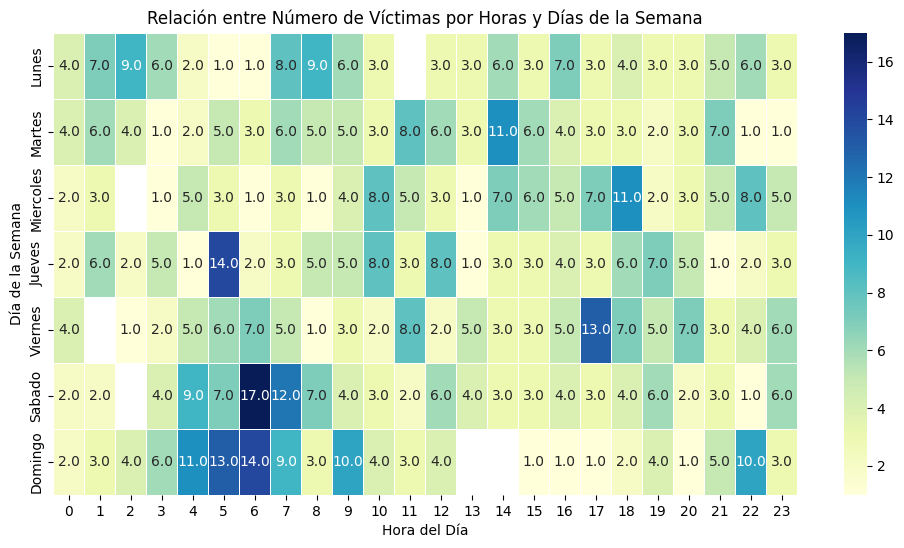

In [55]:
#Agrupa los datos en cantidad de victimas por dia de la semana y horas 
data = df.groupby(['Día semana', "Hora"])['Num víctimas'].sum().reset_index()
data["Hora"]=data["Hora"].astype("Int64")

# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'Orden_dia_semana' en el DataFrame para representar el orden numérico de los días de la semana
data['Orden_dia_semana'] = data['Día semana'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data = data.sort_values(by='Orden_dia_semana')

# Crear una tabla pivot para los datos
pivot_data = data.pivot_table(index= 'Día semana', columns='Hora', values='Num víctimas', aggfunc='sum')
pivot_data = pivot_data.reindex(orden_dias_semana)

# Crear un mapa de calor (heatmap)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='.1f', linewidths=0.5)

# Configurar etiquetas y título
plt.xlabel('Hora del Día')
plt.ylabel('Día de la Semana')
plt.title('Relación entre Número de Víctimas por Horas y Días de la Semana')

# Mostrar el gráfico
plt.show()


### **Conclusión**
- El mes con mayor cantidad de `víctimas fatales` (86) es Diciembre .
- El `Día ` 20 de cada mes es el que lleva el mayor número de víctimas y los días `Sábado y Domingo` tienen la suma de 114 víctimas fatales, siendo la mayor cantidad.
- El mapa de calor indica que los días de fin de semana, en especial sábados y domingos se encuentran con un número más alto de víctimas fatales, siendo las horas entre 03.00 hs y 09.00 hs 

Puede decirse que los horarios con mayor peligrosidad tienen que ver con el ingreso laboral (05:00 hs - 09:00 hs), el horario del mediodía (12:00 hs - 14:00 hs) y salida del trabajo (17:00 hs - 18:00 hs). Durante la madrugada existen pocos siniestros. Y los fines de semana los la cantidad de siniestros es poca pero con mayor cantidad de víctimas

### `Edad` de las víctimas

Se crea un histograma de edades de las víctimas fatales y se utiliza el mismo eje para mostrar las estadísticas de la columna edades a través de un boxplot

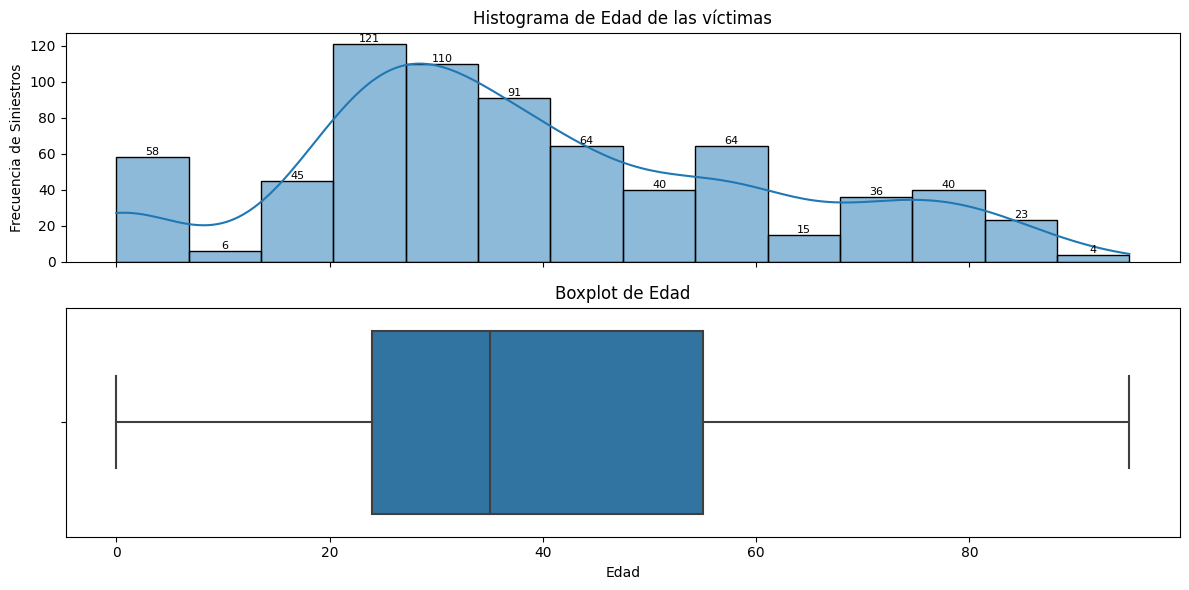

In [65]:
# Se crea una figura con un solo eje x compartido para tener dos gráficos en uno
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Se grafica el histograma de la edad
sns.histplot(df['Edad'], kde=True, ax=ax[0]) #se agrega la línea de suavizado
ax[0].set_title('Histograma de Edad de las víctimas') ; ax[0].set_ylabel('Frecuencia de Siniestros')

# Agregar etiquetas de datos en el histograma
for p in ax[0].patches:
    ax[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=8, color='black')

# Se grafica el boxplot de la edad
sns.boxplot(x=df['Edad'], ax=ax[1])
ax[1].set_title('Boxplot de Edad') ; ax[1].set_xlabel('Edad')

# Se ajusta y muestra el gráfico
plt.tight_layout()
plt.show()
